# Importing Necessary Libraries

In [38]:
# Standard Library
import argparse
import datetime
import gc
import heapq
import math
import os
import pickle
import random
import time

# Third-Party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
from scipy.sparse import coo_matrix
from tabulate import tabulate
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import Module
import torch.sparse

#### Helper Functions to transfer control from GPU to CPU and vice versa

In [39]:
def trans_to_cuda(variable): return variable.cuda() if torch.cuda.is_available() else variable

def trans_to_cpu(variable): return variable.cpu() if torch.cuda.is_available() else variable

# Global Graph Construction

In [40]:
class ItemConv(Module):
    """
    Graph Convolutional Network for item embeddings with attention mechanism.
    Processes item embeddings over a graph structure defined by an adjacency matrix.
    """
    
    def __init__(self, layers, emb_size=100):
        """
        Initialize the ItemConv module
        
        Args:
            layers (int): Number of convolutional layers
            emb_size (int): Size of the embedding vectors
        """
        super(ItemConv, self).__init__()
        self.emb_size = emb_size
        self.layers = layers
        
        # Linear transformation layers without bias for each GCN layer
        self.w_item = nn.ModuleList([
            nn.Linear(self.emb_size, self.emb_size, bias=False)
            for _ in range(self.layers)
        ])
        
        # Attention layer to compute importance weights for items
        self.attention = nn.Linear(self.emb_size, 1)
    
    def forward(self, adjacency, embedding):
        """
        Forward pass of the ItemConv module
        
        Args:
            adjacency: Sparse adjacency matrix (either scipy.sparse or torch.sparse)
            embedding: Initial item embeddings
            
        Returns:
            Updated item embeddings after graph convolution
        """
        # Use full precision for sparse operations to avoid numerical issues
        with torch.amp.autocast('cuda', enabled=False):
            
            # Store initial embedding for residual connection
            item_embedding_layer0 = embedding
            final = item_embedding_layer0
            item_embeddings = embedding
            
            # Convert scipy sparse matrix to torch sparse tensor if needed
            if not isinstance(adjacency, torch.Tensor):
                values = adjacency.data
                indices = np.vstack((adjacency.row, adjacency.col))
                i = torch.LongTensor(indices)
                v = torch.FloatTensor(values)
                shape = adjacency.shape
                adjacency = torch.sparse_coo_tensor(i, v, torch.Size(shape))
                adjacency = trans_to_cuda(adjacency)
            
            # Compute attention weights for each item
            attention_scores = self.attention(item_embeddings)
            attention_weights = F.softmax(attention_scores, dim=0)
            
            # Apply convolutional updates for each layer
            for i in range(self.layers):
                # Apply linear transformation
                item_embeddings = trans_to_cuda(self.w_item[i])(item_embeddings)
                
                # Apply attention weighting
                weighted_embeddings = item_embeddings * attention_weights
                
                # Propagate information through graph using sparse matrix multiplication
                item_embeddings = torch.sparse.mm(adjacency, weighted_embeddings)
                
                # Normalize embedding vectors for stability
                item_embeddings = F.normalize(item_embeddings, dim=-1, p=2)
                
                # Accumulate the output for residual connection
                final = torch.add(item_embeddings, final)
            
            # Final average over all layers (including input) for stable representations
            item_embeddings = final / (self.layers + 1)
            
            return item_embeddings

# CONTRAST Model Architecture

In [41]:
class CONTRAST(Module):
    """
    CONTRAST: Contrastive learning enhanced session-based recommendation model
    """
    
    def __init__(self, adjacency, n_node, lr, layers, l2, dataset, emb_size=100, batch_size=8,
                 temperature=0.1, item_ce_loss_weight=2, item_cl_loss_weight=2, sampled_item_size=30000):
        """
        Initialize the CONTRAST model
        
        Args:
            adjacency: Adjacency matrix representing item-item relationships
            n_node: Number of items/nodes
            lr: Learning rate
            layers: Number of graph convolutional layers
            l2: L2 regularization weight
            dataset: Name of the dataset
            emb_size: Embedding dimension
            batch_size: Training batch size
            temperature: Temperature parameter for contrastive learning
            item_ce_loss_weight: Weight for cross entropy loss
            item_cl_loss_weight: Weight for contrastive learning loss
            sampled_item_size: Number of items to sample for contrastive learning
        """
        super(CONTRAST, self).__init__()

        # General model settings
        self.emb_size = emb_size
        self.batch_size = batch_size
        self.n_node = n_node
        self.dataset = dataset
        self.L2 = l2
        self.lr = lr
        self.layers = layers

        # Contrastive learning and ranking configs
        self.w_k = 10
        self.min_temperature = 0.05
        self.max_temperature = 0.2
        self.temperature_decay = 0.95
        self.use_hard_negatives = True
        self.hard_negative_ratio = 0.3
        self.hard_negative_temp = 0.1

        # Normalize adjacency matrix
        self._prepare_adjacency(adjacency)
        
        # Initialize model components
        self._init_embeddings()
        self._init_transformation_layers()
        self._init_loss_and_optimizer()
        
        # Initialize parameters
        self.init_parameters()

        # Contrastive learning config
        self.temperature = temperature
        self.item_ce_loss_weight = item_ce_loss_weight
        self.item_cl_loss_weight = item_cl_loss_weight
        self.sampled_item_size = min(sampled_item_size, n_node)

    def _prepare_adjacency(self, adjacency):
        """Prepare normalized adjacency matrix"""
        degree = adjacency.sum(axis=0).reshape(1, -1)
        degree = 1 / (degree + 1e-10) # Added a small epsilon to avoid division by zero
        self.adjacency = adjacency.multiply(degree)
    
    def _init_embeddings(self):
        """Initialize embedding layers"""
        self.embedding = nn.Embedding(self.n_node, self.emb_size)
        self.pos_len = 300 if self.dataset == 'RetailRocket' else 200
        self.pos_embedding = nn.Embedding(self.pos_len, self.emb_size)
        self.ItemGraph = ItemConv(self.layers)
    
    def _init_transformation_layers(self):
        """Initialize transformation and attention layers"""
        self.w_1 = nn.Parameter(torch.Tensor(2 * self.emb_size, self.emb_size))
        self.w_2 = nn.Parameter(torch.Tensor(self.emb_size, 1))
        self.w_i = nn.Linear(self.emb_size, self.emb_size)
        self.w_s = nn.Linear(self.emb_size, self.emb_size)
        self.glu1 = nn.Linear(self.emb_size, self.emb_size)
        self.glu2 = nn.Linear(self.emb_size, self.emb_size, bias=False)
    
    def _init_loss_and_optimizer(self):
        """Initialize loss function and optimizer"""
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

    def init_parameters(self):
        """Initialize all model parameters"""
        stdv = 1.0 / math.sqrt(self.emb_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def generate_sess_emb(self, item_embedding, session_item, session_len, reversed_sess_item, mask):
        """
        Generate session embeddings from item embeddings using attention mechanism
        
        Args:
            item_embedding: Item embeddings
            session_item: Items in each session
            session_len: Length of each session
            reversed_sess_item: Items in reversed order
            mask: Mask for padding
            
        Returns:
            Session embeddings
        """
        # Add a zero vector for padding index
        zeros = trans_to_cuda(torch.zeros(1, self.emb_size, dtype=torch.float))
        item_embedding = torch.cat([zeros, item_embedding], 0)

        # Gather embeddings for each session
        seq_h = trans_to_cuda(torch.zeros(self.batch_size, list(reversed_sess_item.shape)[1], self.emb_size, dtype=torch.float))
        for i in torch.arange(session_item.shape[0]):
            seq_h[i] = item_embedding[reversed_sess_item[i]]

        # Compute session-wise average
        hs = torch.div(torch.sum(seq_h, 1), session_len)
        mask = mask.float().unsqueeze(-1)
        len_seq = seq_h.shape[1]

        # Add positional embeddings
        pos_emb = self.pos_embedding.weight[:len_seq].unsqueeze(0).repeat(self.batch_size, 1, 1)

        # Apply attention mechanism
        hs = hs.unsqueeze(-2).repeat(1, len_seq, 1)
        nh = torch.matmul(torch.cat([pos_emb, seq_h], -1), self.w_1)
        nh = torch.tanh(nh)
        nh = torch.sigmoid(self.glu1(nh) + self.glu2(hs))

        beta = torch.matmul(nh, self.w_2)
        beta = beta * mask

        select = torch.sum(beta * seq_h, 1)
        return select

    def compute_cl_loss(self, item_embeddings_i, session_item=None, epoch=0):
        """
        Compute contrastive learning loss
        
        Args:
            item_embeddings_i: Item embeddings
            session_item: Current session items for hard negative sampling
            epoch: Current training epoch
            
        Returns:
            Contrastive learning loss
        """
        # Adaptive temperature decay
        adaptive_temp = max(self.min_temperature, self.max_temperature * (self.temperature_decay ** epoch))

        # Sample subset of items
        if self.n_node > self.sampled_item_size:
            if self.use_hard_negatives and session_item is not None:
                sampled_indices = self.sample_hard_negatives(session_item, item_embeddings_i)
            else:
                sampled_indices = torch.randperm(self.n_node)[:self.sampled_item_size]
            sampled_embeddings = item_embeddings_i[sampled_indices]
        else:
            sampled_embeddings = item_embeddings_i

        # Normalize embeddings
        sampled_embeddings = F.normalize(sampled_embeddings, dim=-1, p=2)

        # Compute contrastive loss in chunks
        bs, _ = sampled_embeddings.shape
        cl_loss = 0
        chunk_size = 1024
        num_chunks = (bs + chunk_size - 1) // chunk_size

        for i in range(num_chunks):
            start_idx = i * chunk_size
            end_idx = min((i + 1) * chunk_size, bs)
            chunk_embed = sampled_embeddings[start_idx:end_idx]
            chunk_logits = torch.matmul(chunk_embed, sampled_embeddings.T) / adaptive_temp

            targets = torch.arange(start_idx, end_idx, dtype=torch.long, device=chunk_logits.device)
            chunk_loss = self.loss_function(chunk_logits, targets)
            cl_loss += chunk_loss * (end_idx - start_idx) / bs

        return self.item_cl_loss_weight * cl_loss

    def sample_hard_negatives(self, session_item, item_embeddings):
        """
        Sample hard negatives with improved memory efficiency
        
        Args:
            session_item (torch.Tensor): Tensor of session items
            item_embeddings (torch.Tensor): Item embeddings tensor
        
        Returns:
            torch.Tensor: Sampled indices for hard negatives
        """
        device = item_embeddings.device
        
        # Safe extraction of unique session items
        try:
            session_unique_items = torch.unique(session_item.cpu()).tolist()
            session_unique_items = [i for i in session_unique_items if i > 0]  # Remove padding
        except Exception:
            session_unique_items = []
        
        # Fallback to random sampling if no valid items
        if not session_unique_items:
            return torch.randperm(self.n_node, device=device)[:self.sampled_item_size]
        
        # Convert to tensor on correct device
        session_unique_items = torch.tensor(session_unique_items, device=device, dtype=torch.long)
        
        # Normalize embeddings
        all_item_norm = F.normalize(item_embeddings, dim=-1, p=2)
        
        # Memory-efficient similarity computation
        similarity_scores = torch.zeros(self.n_node, device=device)
        
        # Compute similarities in a memory-efficient way
        for session_item in session_unique_items:
            # Compute similarity for each session item separately
            item_emb = all_item_norm[session_item].unsqueeze(0)
            batch_sim = torch.matmul(all_item_norm, item_emb.T).squeeze()
            
            # Update similarity scores by taking max
            similarity_scores = torch.maximum(similarity_scores, batch_sim)
        
        # Create sampling mask, excluding session items
        sampling_mask = torch.ones(self.n_node, dtype=torch.bool, device=device)
        sampling_mask[session_unique_items] = False
        
        # Apply mask to similarity scores
        similarity_scores[~sampling_mask] = float('-inf')
        
        # Normalize similarity scores with temperature
        sampling_weights = torch.softmax(similarity_scores / self.hard_negative_temp, dim=0)
        
        # Sampling parameters
        num_hard_negatives = max(1, int(self.sampled_item_size * self.hard_negative_ratio))
        num_random_negatives = self.sampled_item_size - num_hard_negatives
        
        try:
            # Sample hard negatives
            hard_negative_indices = torch.multinomial(
                sampling_weights, num_hard_negatives, replacement=False)
            
            # Prepare for random negative sampling
            eligible_mask = sampling_mask.clone()
            eligible_mask[hard_negative_indices] = False
            eligible_indices = torch.nonzero(eligible_mask).squeeze()
            
            # Sample random negatives
            if len(eligible_indices) >= num_random_negatives:
                random_perm = torch.randperm(len(eligible_indices))[:num_random_negatives]
                random_negative_indices = eligible_indices[random_perm]
            else:
                # Fallback: sample with replacement
                random_negative_indices = eligible_indices[
                    torch.randint(0, len(eligible_indices), (num_random_negatives,))
                ]
            
            # Combine hard and random negatives
            sampled_indices = torch.cat([hard_negative_indices, random_negative_indices])
            
        except Exception:
            # Absolute fallback to random sampling
            sampled_indices = torch.randperm(self.n_node, device=device)[:self.sampled_item_size]
        
        return sampled_indices

    def forward(self, session_item, session_len, reversed_sess_item, mask, epoch, tar, train):
        """
        Forward pass of the model
        
        Args:
            session_item: Items in each session
            session_len: Length of each session
            reversed_sess_item: Items in reversed order
            mask: Mask for padding
            epoch: Current training epoch
            tar: Target items
            train: Whether in training mode
            
        Returns:
            Tuple of (loss_item, scores_item, cl_loss)
        """
        # Graph-based item embeddings (no AMP for sparse ops)
        with torch.amp.autocast('cuda', enabled=False):
            item_embeddings_i = self.ItemGraph(self.adjacency, self.embedding.weight)

        with torch.amp.autocast('cuda', enabled=False):
            # Generate session embeddings
            sess_emb_i = self.generate_sess_emb(item_embeddings_i, session_item, session_len, reversed_sess_item, mask)
            sess_emb_i = self.w_k * F.normalize(sess_emb_i, dim=-1, p=2)

            # Compute recommendation scores
            item_embeddings_i_norm = F.normalize(item_embeddings_i, dim=-1, p=2)
            scores_item = torch.mm(sess_emb_i, torch.transpose(item_embeddings_i_norm, 1, 0))
            loss_item = self.loss_function(scores_item, tar) * self.item_ce_loss_weight

        # Compute contrastive learning loss if in training mode
        cl_loss = 0
        if train:
            with torch.amp.autocast(device_type='cuda', enabled=False):
                cl_loss = self.compute_cl_loss(item_embeddings_i, session_item, epoch)

        return loss_item, scores_item, cl_loss

## Model Run

In [42]:
# Memory-efficient forward function for model execution
def forward(model, i, data, epoch, train):
    """
    Process a slice of data through the model with memory efficiency in mind
    
    Args:
        model: The neural network model
        i: Slice index
        data: Dataset object containing the training/testing data
        epoch: Current training epoch
        train: Boolean indicating if in training mode
        
    Returns:
        Tuple of (targets, scores, loss, contrastive_loss)
    """
    # Get data slice components
    tar, session_len, session_item, reversed_sess_item, mask = data.get_slice(i)
    
    # Convert to tensors and move to device
    session_item = trans_to_cuda(torch.Tensor(session_item).long())
    session_len = trans_to_cuda(torch.Tensor(session_len).long())
    tar = trans_to_cuda(torch.Tensor(tar).long())
    mask = trans_to_cuda(torch.Tensor(mask).long())
    reversed_sess_item = trans_to_cuda(torch.Tensor(reversed_sess_item).long())
    
    # Forward pass through the model - passing epoch parameter
    loss_item, scores_item, cl_item_loss = model(
        session_item, 
        session_len, 
        reversed_sess_item, 
        mask, 
        epoch, 
        tar, 
        train
    )
    
    return tar, scores_item, loss_item, cl_item_loss


@jit(nopython=True)
def find_k_largest(K, candidates):
    """
    Find the indices of the K largest values in candidates array using a heap
    
    Args:
        K: Number of largest elements to find
        candidates: Array of scores
        
    Returns:
        List of indices corresponding to K largest values
    """
    n_candidates = []
    
    # Initialize heap with first K elements
    for iid, score in enumerate(candidates[:K]):
        n_candidates.append((score, iid))
    heapq.heapify(n_candidates)
    
    # Replace smallest element in heap if we find a larger one
    for iid, score in enumerate(candidates[K:]):
        if score > n_candidates[0][0]:
            heapq.heapreplace(n_candidates, (score, iid + K))
    
    # Sort results in descending order
    n_candidates.sort(key=lambda d: d[0], reverse=True)
    
    # Extract indices
    ids = [item[1] for item in n_candidates]
    return ids


def train_test(model, train_data, test_data, epoch):
    """
    Main training and testing function with mixed precision and memory optimizations
    
    Args:
        model: Model to train and evaluate
        train_data: Training dataset
        test_data: Testing dataset
        epoch: Current epoch number
        
    Returns:
        Tuple of (evaluation metrics, total training loss)
    """
    print('start training: ', datetime.datetime.now())
    total_loss = 0.0
    
    # Set model to training mode
    model.train()
    
    # Initialize mixed precision scaler
    scaler = torch.amp.GradScaler('cuda')
    
    # Set up gradient accumulation to save memory
    accumulation_steps = 64  # Increased for better batching
    slices = train_data.generate_batch(model.batch_size)
    
    # Training loop
    for i, slice_idx in enumerate(tqdm(slices, desc="Training Loop", leave=False)):
        # Forward pass with selective mixed precision
        tar, scores_item, loss_item, cl_item_loss = forward(model, slice_idx, train_data, epoch, train=True)
        
        # Combine losses
        loss = loss_item + cl_item_loss
        
        # Normalize the loss for gradient accumulation
        loss = loss / accumulation_steps
        
        # Use scaler for mixed precision training
        scaler.scale(loss).backward()
        
        # Only update weights after accumulation_steps or at the end
        if (i + 1) % accumulation_steps == 0 or i == len(slices) - 1:
            # Unscale before optimizer step to avoid potential FP16 overflow
            scaler.unscale_(model.optimizer)
            
            # Apply gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            
            # Perform optimization step and update scaler
            scaler.step(model.optimizer)
            scaler.update()
            
            # Reset gradients
            model.optimizer.zero_grad()
            
        # Scale back the loss for reporting
        total_loss += loss.item() * accumulation_steps
    
    # Free memory at end of training epoch
    torch.cuda.empty_cache()
    gc.collect()
        
    print('\tLoss:\t%.3f' % total_loss)
    
    # Set up metrics for evaluation
    top_K = [5, 10, 20]
    metrics = {}
    for K in top_K:
        metrics['hit%d' % K] = []
        metrics['mrr%d' % K] = []
    
    print('start predicting: ', datetime.datetime.now())

    # Set model to evaluation mode
    model.eval()
    
    # Process test data in batches with no gradients
    with torch.no_grad():
        slices = test_data.generate_batch(model.batch_size)
        
        for slice_idx in tqdm(slices, desc="Testing Loop", leave=False):
            # Get predictions for this batch
            tar, scores_item, loss_item, cl_item_loss = forward(model, slice_idx, test_data, epoch, train=False)
            scores = trans_to_cpu(scores_item).detach().numpy()
            
            # Find top K items for each sample in batch
            index = []
            for idd in range(model.batch_size):
                index.append(find_k_largest(20, scores[idd]))
            index = np.array(index)
            
            # Move targets to CPU for evaluation
            tar = trans_to_cpu(tar).detach().numpy()
            
            # Calculate metrics for each K value
            for K in top_K:
                for prediction, target in zip(index[:, :K], tar):
                    # Hit rate: whether target is in top K predictions
                    metrics['hit%d' % K].append(np.isin(target, prediction))
                    
                    # MRR (Mean Reciprocal Rank): 1/rank if found, 0 if not found
                    if len(np.where(prediction == target)[0]) == 0:
                        metrics['mrr%d' % K].append(0)
                    else:
                        metrics['mrr%d' % K].append(1 / (np.where(prediction == target)[0][0] + 1))
        
        # Clean up memory after evaluation
        torch.cuda.empty_cache()
            
    return metrics, total_loss

## Data Handling

In [43]:
class Data():
    
    def __init__(self, data, all_train, hoplimit, shuffle=False, n_node=None):
        """
        Initialize the data container with optimized memory usage
        
        Args:
            data: Tuple of (raw_sessions, targets)
            all_train: All training sessions for building adjacency matrix
            hoplimit: Maximum hop distance to consider in graph
            shuffle: Whether to shuffle data during batch generation
            n_node: Total number of nodes in the graph
        """
        self.raw = np.asarray(data[0], dtype=object)
        
        # Compute adjacency matrix more efficiently
        print("Computing adjacency matrix...")
        adj = data_masks(all_train, n_node, hoplimit)
        
        # Calculate normalized adjacency matrix
        adj_sum = adj.sum(axis=0)
        # Avoid division by zero with small epsilon
        adj_sum_safe = np.maximum(adj_sum, 1e-10)
        # Normalize adjacency by outgoing edge weights
        self.adjacency = adj.multiply(1.0 / adj_sum_safe.reshape(1, -1))
        
        self.n_node = n_node
        self.targets = np.asarray(data[1])
        self.length = len(self.raw)
        self.shuffle = shuffle

    def generate_batch(self, batch_size):
        """
        Generate batches of indices for training/testing
        
        Args:
            batch_size: Size of each batch
            
        Returns:
            List of index slices for batches
        """
        # Shuffle data if requested
        if self.shuffle:
            shuffled_arg = np.arange(self.length)
            np.random.shuffle(shuffled_arg)
            self.raw = self.raw[shuffled_arg]
            self.targets = self.targets[shuffled_arg]
        
        # Calculate number of batches
        n_batch = int(self.length / batch_size)
        if self.length % batch_size != 0:
            n_batch += 1
            
        # Split data into batches
        slices = np.split(np.arange(n_batch * batch_size), n_batch)
        # Fix the last batch to have correct indices
        slices[-1] = np.arange(self.length - batch_size, self.length)
        
        return slices

    def get_slice(self, index):
        """
        Retrieve and prepare a slice of data for model processing
        
        Args:
            index: Indices for the batch
            
        Returns:
            Tuple of (targets, session_len, items, reversed_sess_item, mask)
        """
        items, num_node = [], []
        inp = self.raw[index]
        
        # Calculate session lengths and find maximum
        for session in inp:
            num_node.append(len(np.nonzero(session)[0]))
        max_n_node = np.max(num_node)
        
        # Initialize containers
        session_len = []
        reversed_sess_item = []
        mask = []
        
        # Process each session
        for session in inp:
            nonzero_elems = np.nonzero(session)[0]
            session_len.append([len(nonzero_elems)])
            
            # Pad items to max length
            items.append(session + (max_n_node - len(nonzero_elems)) * [0])
            
            # Create mask to handle variable-length sessions
            mask.append([1] * len(nonzero_elems) + (max_n_node - len(nonzero_elems)) * [0])
            
            # Create reversed session with padding
            reversed_sess_item.append(list(reversed(session)) + (max_n_node - len(nonzero_elems)) * [0])
        
        return self.targets[index] - 1, session_len, items, reversed_sess_item, mask


# Optimized implementation of data_masks
def data_masks(all_sessions, n_node, hoplimit):
    """
    Build a sparse adjacency matrix from sessions with hop-based weighting
    
    Args:
        all_sessions: List of all sessions (item sequences)
        n_node: Total number of nodes in the graph
        hoplimit: Maximum hop distance to consider
        
    Returns:
        Sparse adjacency matrix as a COO matrix
    """
    print(f"Building graph with {len(all_sessions)} sessions and hop limit {hoplimit}...")
    
    # Preprocess to reduce memory usage
    row, col, data = [], [], []
    
    # Process in chunks to save memory
    chunk_size = 1000
    num_chunks = (len(all_sessions) + chunk_size - 1) // chunk_size
    
    for chunk_idx in range(num_chunks):
        # Get current chunk bounds
        start_idx = chunk_idx * chunk_size
        end_idx = min((chunk_idx + 1) * chunk_size, len(all_sessions))
        chunk_sessions = all_sessions[start_idx:end_idx]
        
        # Process each session in the chunk
        for sess in chunk_sessions:
            for i, item in enumerate(sess):
                if i == len(sess) - 1:
                    continue  # Skip last item as it has no next item
                    
                # Calculate relations within hop limit
                start_j = max(0, i - hoplimit)
                end_j = min(i + hoplimit + 1, len(sess))
                
                # Add edges for each item within hop limit
                for j in range(start_j, end_j):
                    if i == j:  # Self-connection with weight 1
                        row.append(sess[i] - 1)
                        col.append(sess[i] - 1)
                        data.append(1.0)
                    else:
                        # Weight is inversely proportional to distance
                        distance = abs(j - i)
                        weight = 1.0 / (distance + 1)
                        
                        # Add weighted edge
                        row.append(sess[i] - 1)
                        col.append(sess[j] - 1)
                        data.append(weight)
    
    # Create sparse matrix from COO format
    print(f"Creating sparse matrix with {len(row)} edges...")
    coo = coo_matrix((data, (row, col)), shape=(n_node, n_node))
    
    return coo

## Data Loading

In [44]:
def load_dataset(dataset_name, train_limit=None):
    """
    Load dataset files with optional size limiting
    
    Args:
        dataset_name: Name of the dataset ('retail_rocket' or 'diginetica')
        train_limit: Optional size limit for training data
        
    Returns:
        Tuple of (train_data, test_data, all_train, n_node)
    """
    # To avoid any bugs
    if dataset_name not in ["RetailRocket", "Diginetica"]:
        raise ValueError(f"Dataset {dataset_name} not supported. Choose from: {list(DATASET_PATHS.keys())}")
    
    print(f"Loading {dataset_name} dataset...")
    
    path = f'/kaggle/input/contrast-preprocessed-datasets/{dataset_name}'
    
    # Load training data
    train_data = pickle.load(open(f'{path}/train.txt', 'rb'))
    if train_limit is not None:
        print(f"Limiting training data to {train_limit} samples")
        train_data = train_data[:train_limit]
    train_data = (train_data[0], train_data[1])
    
    # Load test data
    test_data = pickle.load(open(f'{path}/test.txt', 'rb'))
    if train_limit is not None:  # Also limit test data proportionally
        test_limit = min(train_limit // 4, len(test_data))
        print(f"Limiting test data to {test_limit} samples")
        test_data = test_data[:test_limit]
    test_data = (test_data[0], test_data[1])
    
    # Load all training sequences
    all_train = pickle.load(open(f'{path}/all_train_seq.txt', 'rb'))

    n_node = 41762 if dataset_name == "RetailRocket" else 37867
    
    return train_data, test_data, all_train, n_node

In [45]:
def prepare_data(train_data, test_data, all_train, hoplimit, n_node):
    """
    Prepare Data objects for training and testing
    
    Args:
        train_data: Training data tuple
        test_data: Test data tuple
        all_train: All training sequences
        hoplimit: Maximum hop limit for graph construction
        n_node: Number of nodes in the graph
        
    Returns:
        Tuple of (train_data_obj, test_data_obj)
    """
    print("Initializing training data...")
    train_data_obj = Data(train_data, all_train, hoplimit, shuffle=True, n_node=n_node)
    
    print("Initializing test data...")
    test_data_obj = Data(test_data, all_train, hoplimit, shuffle=False, n_node=n_node)
    
    return train_data_obj, test_data_obj

### Model Creation

In [46]:
def create_model(train_data_obj, config, dataset, n_node):
    """
    Create and initialize the model
    
    Args:
        train_data_obj: Training data object with adjacency matrix
        config: Configuration dictionary
        n_node: Number of nodes in the graph
        
    Returns:
        Initialized model
    """
    print("Creating model...")
    model = trans_to_cuda(CONTRAST(
        adjacency=train_data_obj.adjacency,
        n_node=n_node,
        dataset=dataset,
        lr=config["lr"],
        l2=config["l2"],
        layers=config["layer"],
        emb_size=config["embSize"],
        batch_size=config["batchSize"],
        temperature=config["temperature"],
        item_ce_loss_weight=config["item_ce_loss_weight"],
        item_cl_loss_weight=config["item_cl_loss_weight"],
        sampled_item_size=config["sampled_item_size"],
    ))
    
    return model

### Seed Setup

In [47]:
def setup_environment(seed):
    """
    Set up the environment with deterministic behavior for reproducibility
    
    Args:
        seed: Random seed for reproducibility
    """
    # Set memory management for PyTorch
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128,expandable_segments:True'
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    # Set random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        print("CUDA not available, using CPU")

### Configuration Settings

In [48]:
# Default hyperparameters
# You may tweak the parameters as per your needs
DEFAULT_CONFIG = {
    "epoch": 5,  # Reduced for demonstration — crank it up if you've got the time (and the GPU)
    "batchSize": 256, 
    "embSize": 100,
    "l2": 1e-5,
    "lr": 0.001, # Learning Rate for the Adam optimizer
    "layer": 3,  # Number of Graph Convolution Layers   
    "temperature": 0.7,
    "item_ce_loss_weight": 0.3, # alpha
    "item_cl_loss_weight": 3, # beta
    "sampled_item_size": 5000,
    "hoplimit": 3, 
    "seed": 42, # Set the seed for reproducibility
    "train_limit": None  # Data size limit to train on a subset
}

# Run Training

In [49]:
def main():
    
    """Main function for session-based recommendation training"""
    
    print("=" * 50)
    print("Session-based Recommendation Training")
    print("=" * 50)
    
    print("\nSelect dataset:")
    print("1. Retail Rocket")
    print("2. Diginetica")
    
    dataset_choice = input("Enter your choice (1 or 2): ").strip()
    dataset_mapping = {
        '1': "RetailRocket",
        '2': "Diginetica"
    }
    
    dataset_name = dataset_mapping.get(dataset_choice, "Diginetica")
    if dataset_choice not in dataset_mapping:
        print("Invalid choice. Defaulting to Diginetica.")  
    
    # Create configuration
    config = DEFAULT_CONFIG.copy()
    
    # Want to modify hyperparameters?
    print("\nDo you want to modify hyperparameters?")
    modify_params = input("Enter 'y' for yes, any other key to use defaults: ").strip().lower()
    
    if modify_params == 'y':
        config["batchSize"] = int(input(f"Batch size (default {config['batchSize']}): ") or config["batchSize"])
        config["epoch"] = int(input(f"Number of epochs (default {config['epoch']}): ") or config["epoch"])
        config["lr"] = float(input(f"Learning rate (default {config['lr']}): ") or config["lr"])
        config["layer"] = int(input(f"Number of layers (default {config['layer']}): ") or config["layer"])
        config["temperature"] = float(input(f"Temperature (default {config['temperature']}): ") or config["temperature"])
        config["hoplimit"] = int(input(f"Hoplimit (default {config['hoplimit']}): ") or config["hoplimit"])
        config["item_ce_loss_weight"] = float(input(f"Weight for Cross Entropy Loss or Alpha (default {config['item_ce_loss_weight']}): ") or config["item_ce_loss_weight"])
        config["item_cl_loss_weight"] = float(input(f"Weight for Contrastive Learning Loss or Beta (default {config['item_cl_loss_weight']}): ") or config["item_cl_loss_weight"])
        config["train_limit"] = int(input(f"Training data limit (default {config['train_limit']})") or 0) or config["train_limit"]
    
    # Set up environment
    setup_environment(config["seed"])
    
    # Load dataset
    train_data, test_data, all_train, n_node = load_dataset(dataset_name, config["train_limit"])
    
    # Prepare data objects
    train_data_obj, test_data_obj = prepare_data(train_data, test_data, all_train, config["hoplimit"], n_node)
    
    # Create and initialize model
    model = create_model(train_data_obj, config, dataset_name, n_node)
    
    # Initialize top-K tracking
    top_K = [5, 10, 20]
    best_results = {}
    epoch_metrics = {}
    epoch_numbers = []
    
    # Initialize dictionaries
    for K in top_K:
        best_results[f'epoch{K}'] = [0, 0]       # [epoch for best Recall@K, epoch for best MRR@K]
        best_results[f'metric{K}'] = [0.0, 0.0]  # [best Recall@K, best MRR@K]
        epoch_metrics[f'hit@{K}'] = []
        epoch_metrics[f'mrr@{K}'] = []
    
    # Training loop
    print("\nStarting training...\n")
    print("-" * 50)
    
    for epoch in range(1, config["epoch"] + 1):
        print(f'Epoch: {epoch}/{config["epoch"]}')
        print(f'Memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB')
        
        # Clear cache
        torch.cuda.empty_cache()
        gc.collect()
        
        # Train and test
        metrics, total_loss = train_test(model, train_data_obj, test_data_obj, epoch)
        
        # Log epoch number
        epoch_numbers.append(epoch)
        
        # Process metrics
        for K in top_K:
            metrics[f'hit{K}'] = np.mean(metrics[f'hit{K}']) * 100
            metrics[f'mrr{K}'] = np.mean(metrics[f'mrr{K}']) * 100
            
            # Save for plotting
            epoch_metrics[f'hit@{K}'].append(metrics[f'hit{K}'])
            epoch_metrics[f'mrr@{K}'].append(metrics[f'mrr{K}'])
    
            # Update best metrics
            if best_results[f'metric{K}'][0] < metrics[f'hit{K}']:
                best_results[f'metric{K}'][0] = metrics[f'hit{K}']
                best_results[f'epoch{K}'][0] = epoch
    
            if best_results[f'metric{K}'][1] < metrics[f'mrr{K}']:
                best_results[f'metric{K}'][1] = metrics[f'mrr{K}']
                best_results[f'epoch{K}'][1] = epoch
        
        # Print current epoch metrics
        print(f"Loss: {total_loss:.4f}")
        for K in top_K:
            print(f"Recall@{K}: {metrics[f'hit{K}']:.2f}%, MRR@{K}: {metrics[f'mrr{K}']:.2f}%")
        print("-" * 50)

    print("\nTraining completed!")
    
    # Print best results
    print("\nBest Results:")
    for K in top_K:
        print(f"Best Recall@{K}: {best_results[f'metric{K}'][0]:.2f}% (Epoch {best_results[f'epoch{K}'][0]})")
        print(f"Best MRR@{K}: {best_results[f'metric{K}'][1]:.2f}% (Epoch {best_results[f'epoch{K}'][1]})")

    # A pool of distinct colors — because research plots deserve to look good too
    color_pool = [
        "tab:blue", "tab:orange", "tab:green", "tab:red",
        "tab:purple", "tab:brown", "tab:pink", "tab:gray",
        "tab:olive", "tab:cyan"
    ]

    # Plotting charts
    for K in top_K:
        
        # Pick two random colors for Recall and MRR
        recall_color = random.choice(color_pool)
        mrr_color = random.choice([c for c in color_pool if c != recall_color])
    
        plt.figure(figsize=(12, 5))
        plt.plot(epoch_numbers, epoch_metrics[f'hit@{K}'], label=f'Recall@{K}',
                 color=recall_color, linewidth=2)
        plt.plot(epoch_numbers, epoch_metrics[f'mrr@{K}'], label=f'MRR@{K}',
                 color=mrr_color, linewidth=2)
        
        plt.xlabel("Epoch", fontsize=12)
        plt.ylabel("Metric (%)", fontsize=12)
        plt.title(f"Recall@{K} and MRR@{K} over Epochs", fontsize=14)
        plt.legend(fontsize=10)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    # Best results summary table
    table_data = []
    for K in top_K:
        table_data.append([
            K,
            f"{best_results[f'metric{K}'][0]:.2f}%",
            best_results[f'epoch{K}'][0],
            f"{best_results[f'metric{K}'][1]:.2f}%",
            best_results[f'epoch{K}'][1]
        ])
    
    headers = ["K", "Best Recall@K (%)", "Recall Best Epoch", "Best MRR@K (%)", "MRR Best Epoch"]
    
    print("\nBest Metrics Summary:")
    print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

Session-based Recommendation Training

Select dataset:
1. Retail Rocket
2. Diginetica


Enter your choice (1 or 2):  1



Do you want to modify hyperparameters?


Enter 'y' for yes, any other key to use defaults:  y
Batch size (default 256):  
Number of epochs (default 5):  
Learning rate (default 0.001):  
Number of layers (default 3):  
Temperature (default 0.7):  
Hoplimit (default 3):  
Weight for Cross Entropy Loss or Alpha (default 0.3):  
Weight for Contrastive Learning Loss or Beta (default 3):  
Training data limit (default None) 


Using GPU: Tesla P100-PCIE-16GB
Loading RetailRocket dataset...
Initializing training data...
Computing adjacency matrix...
Building graph with 224747 sessions and hop limit 3...
Creating sparse matrix with 2476792 edges...
Initializing test data...
Computing adjacency matrix...
Building graph with 224747 sessions and hop limit 3...
Creating sparse matrix with 2476792 edges...
Creating model...

Starting training...

--------------------------------------------------
Epoch: 1/5
Memory allocated: 0.03 GB
start training:  2025-05-11 16:21:05.731975


Training Loop:   0%|          | 0/2212 [00:00<?, ?it/s]

	Loss:	29827.534
start predicting:  2025-05-11 16:32:01.383612


Testing Loop:   0%|          | 0/564 [00:00<?, ?it/s]

Loss: 29827.5345
Recall@5: 41.64%, MRR@5: 33.11%
Recall@10: 45.70%, MRR@10: 33.66%
Recall@20: 49.72%, MRR@20: 33.94%
--------------------------------------------------
Epoch: 2/5
Memory allocated: 0.09 GB
start training:  2025-05-11 16:33:33.669827


Training Loop:   0%|          | 0/2212 [00:00<?, ?it/s]

	Loss:	25002.579
start predicting:  2025-05-11 16:44:45.188610


Testing Loop:   0%|          | 0/564 [00:00<?, ?it/s]

Loss: 25002.5792
Recall@5: 46.51%, MRR@5: 34.07%
Recall@10: 52.98%, MRR@10: 34.93%
Recall@20: 59.17%, MRR@20: 35.36%
--------------------------------------------------
Epoch: 3/5
Memory allocated: 0.09 GB
start training:  2025-05-11 16:46:12.104632


Training Loop:   0%|          | 0/2212 [00:00<?, ?it/s]

	Loss:	22858.675
start predicting:  2025-05-11 16:57:09.804882


Testing Loop:   0%|          | 0/564 [00:00<?, ?it/s]

Loss: 22858.6751
Recall@5: 48.19%, MRR@5: 34.45%
Recall@10: 55.49%, MRR@10: 35.43%
Recall@20: 62.31%, MRR@20: 35.90%
--------------------------------------------------
Epoch: 4/5
Memory allocated: 0.09 GB
start training:  2025-05-11 16:58:39.032416


Training Loop:   0%|          | 0/2212 [00:00<?, ?it/s]

	Loss:	20888.309
start predicting:  2025-05-11 17:09:35.427778


Testing Loop:   0%|          | 0/564 [00:00<?, ?it/s]

Loss: 20888.3087
Recall@5: 49.00%, MRR@5: 34.63%
Recall@10: 56.82%, MRR@10: 35.68%
Recall@20: 63.89%, MRR@20: 36.17%
--------------------------------------------------
Epoch: 5/5
Memory allocated: 0.09 GB
start training:  2025-05-11 17:11:04.356963


Training Loop:   0%|          | 0/2212 [00:00<?, ?it/s]

	Loss:	18945.194
start predicting:  2025-05-11 17:21:56.904201


Testing Loop:   0%|          | 0/564 [00:00<?, ?it/s]

Loss: 18945.1944
Recall@5: 49.51%, MRR@5: 34.78%
Recall@10: 57.58%, MRR@10: 35.87%
Recall@20: 64.83%, MRR@20: 36.38%
--------------------------------------------------

Training completed!

Best Results:
Best Recall@5: 49.51% (Epoch 5)
Best MRR@5: 34.78% (Epoch 5)
Best Recall@10: 57.58% (Epoch 5)
Best MRR@10: 35.87% (Epoch 5)
Best Recall@20: 64.83% (Epoch 5)
Best MRR@20: 36.38% (Epoch 5)


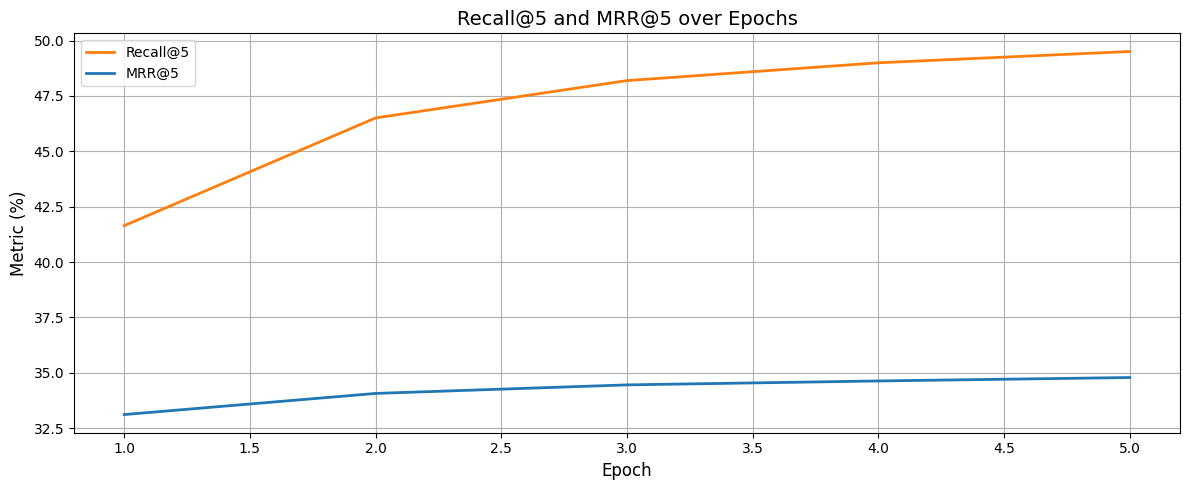

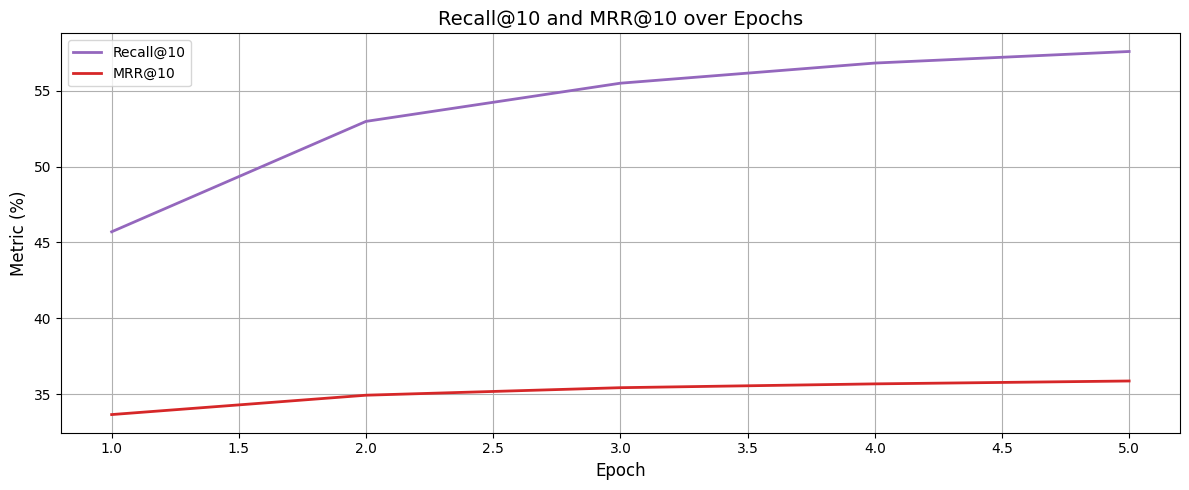

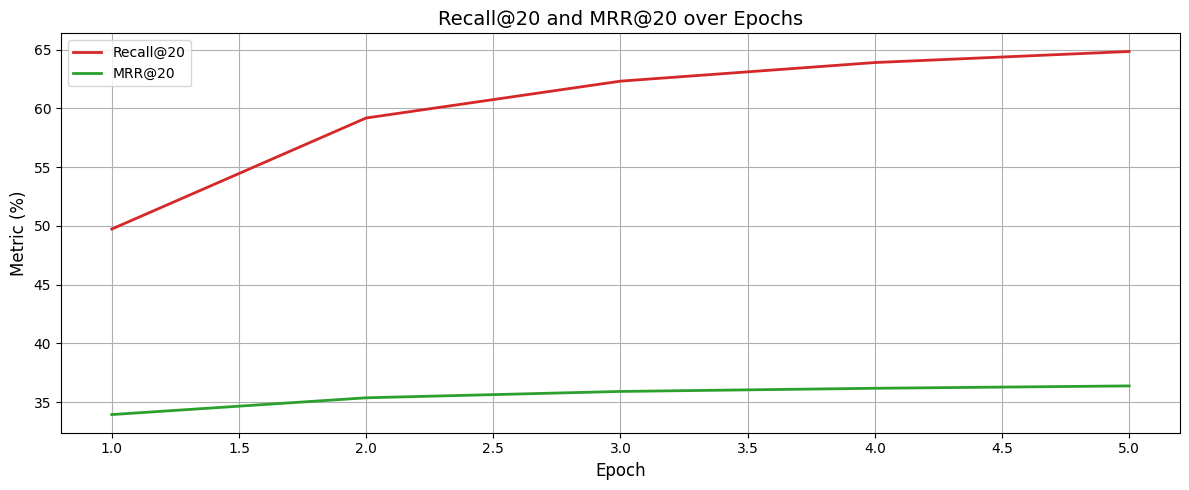


Best Metrics Summary:
╒═════╤═════════════════════╤═════════════════════╤══════════════════╤══════════════════╕
│   K │ Best Recall@K (%)   │   Recall Best Epoch │ Best MRR@K (%)   │   MRR Best Epoch │
╞═════╪═════════════════════╪═════════════════════╪══════════════════╪══════════════════╡
│   5 │ 49.51%              │                   5 │ 34.78%           │                5 │
├─────┼─────────────────────┼─────────────────────┼──────────────────┼──────────────────┤
│  10 │ 57.58%              │                   5 │ 35.87%           │                5 │
├─────┼─────────────────────┼─────────────────────┼──────────────────┼──────────────────┤
│  20 │ 64.83%              │                   5 │ 36.38%           │                5 │
╘═════╧═════════════════════╧═════════════════════╧══════════════════╧══════════════════╛


In [50]:
if __name__ == "__main__":
    main()